In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras

In [3]:
df_train_full = pd.read_csv('../data/train.csv', dtype={'Id': str})
df_train_full['filename'] = '../data/images/' + df_train_full['Id'] + '.jpg'
df_train_full.head()

,Id,label,filename
0,0560,glass,../data/images/0560.jpg
1,4675,cup,../data/images/4675.jpg
2,0875,glass,../data/images/0875.jpg
3,4436,spoon,../data/images/4436.jpg
4,8265,plate,../data/images/8265.jpg


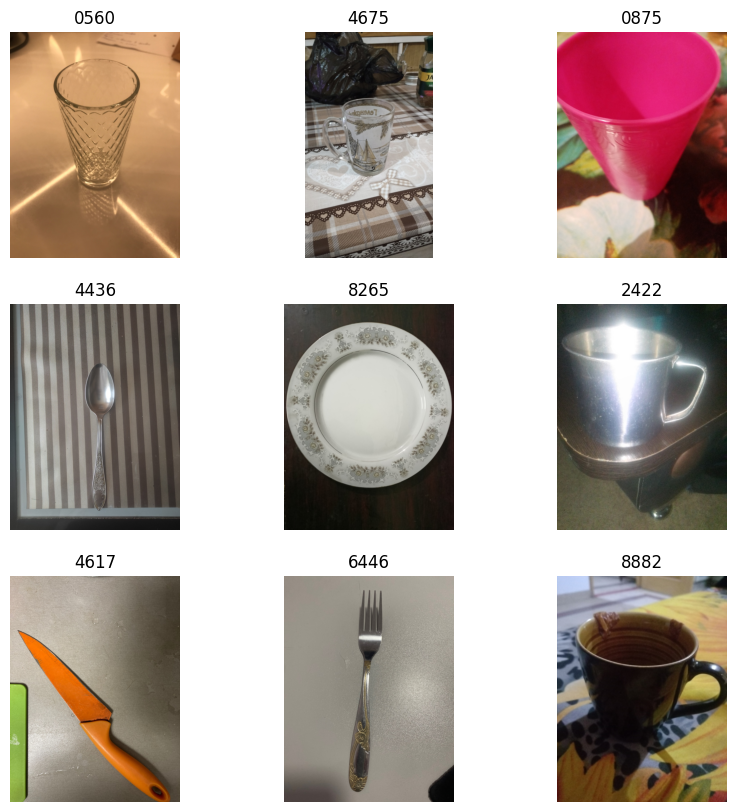

In [14]:
## Visualizing the data

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = mpimg.imread(df_train_full['filename'][i])
    plt.imshow(img)
    plt.title(df_train_full['Id'][i])
    plt.axis('off')

In [4]:
## Split the data
val_cutoff = int(len(df_train_full) * 0.8)
df_train = df_train_full[:val_cutoff]
df_val = df_train_full[val_cutoff:]

In [5]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [25]:
#Preprocess using transfer learning 
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
)

Found 4447 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.


In [24]:
## Train generator class-indices
train_generator.class_indices

{'cup': 0, 'fork': 1, 'glass': 2, 'knife': 3, 'plate': 4, 'spoon': 5}

In [21]:
## Model
## Input shape (150,150,3)
## Conv2D layer with 32 filters
## Kernel (3,3) (size of the filter)
## Activation function: relu
## MaxPooling2D layer with pool size (2,2)
## Flatten layer
## Dense layer with 64 neurons
## Activation function: relu
## Dense layer with 4 neurons
## Activation function: softmax
inputs = keras.Input(shape = (150,150,3))
x = keras.layers.Conv2D(32, (3,3), activation = 'relu')(inputs)
x = keras.layers.MaxPooling2D((2,2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation = 'relu')(x)
outputs = keras.layers.Dense(6, activation = 'softmax')(x)

In [22]:
## As optimizer I'll use SGD with lr = 0.002 and momentum = 0.8
model = keras.Model(inputs = inputs, outputs = outputs)
lr= 0.002
momentum= 0.9
optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
#best loss function for multiclass classification:categorical_crossentropy
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [23]:
## Model Summary
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 175232)            0         
                                                                 
 dense_5 (Dense)             (None, 64)                11214912  
                                                                 
 dense_6 (Dense)             (None, 6)                 390       
                                                           

In [26]:
## epochs = 10

history = model.fit(train_generator, epochs = 10, validation_data = val_generator)

Epoch 1/10
139/139 [==============================] - 52s 370ms/step - loss: 1.5375 - accuracy: 0.3908 - val_loss: 1.4129 - val_accuracy: 0.4209
Epoch 2/10
139/139 [==============================] - 49s 352ms/step - loss: 1.2993 - accuracy: 0.4891 - val_loss: 1.3060 - val_accuracy: 0.4559
Epoch 3/10
139/139 [==============================] - 46s 333ms/step - loss: 1.1304 - accuracy: 0.5644 - val_loss: 1.1873 - val_accuracy: 0.5216
Epoch 4/10
139/139 [==============================] - 47s 335ms/step - loss: 0.9630 - accuracy: 0.6481 - val_loss: 1.1682 - val_accuracy: 0.5387
Epoch 5/10
139/139 [==============================] - 50s 357ms/step - loss: 0.8043 - accuracy: 0.7018 - val_loss: 1.0938 - val_accuracy: 0.5656
Epoch 6/10
139/139 [==============================] - 50s 363ms/step - loss: 0.6435 - accuracy: 0.7742 - val_loss: 1.1204 - val_accuracy: 0.5881
Epoch 7/10
139/139 [==============================] - 52s 374ms/step - loss: 0.4933 - accuracy: 0.8370 - val_loss: 1.1197 - val_ac

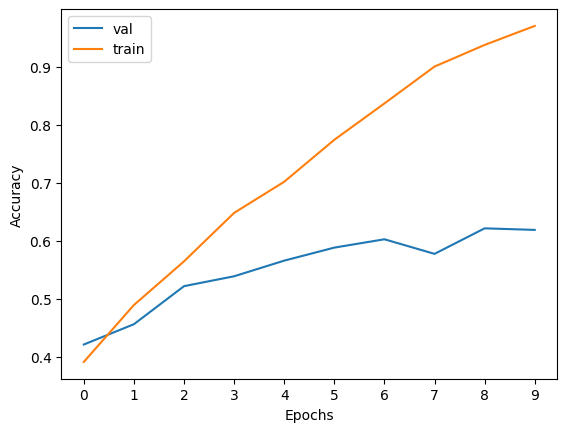

In [28]:
#plot accuracy on validation set

plt.plot(history.history['val_accuracy'], label = 'val')
plt.plot(history.history['accuracy'], label = 'train')
plt.legend()
plt.xticks(np.arange(10))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


In [29]:
## Adjusting the learning rate

def make_model(learning_rate = 0.01):
    inputs = keras.Input(shape = (150,150,3))
    x = keras.layers.Conv2D(32, (3,3), activation = 'relu')(inputs)
    x = keras.layers.MaxPooling2D((2,2))(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(64, activation = 'relu')(x)
    outputs = keras.layers.Dense(6, activation = 'softmax')(x)

    model = keras.Model(inputs = inputs, outputs = outputs)
    lr= learning_rate
    momentum= 0.9
    optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model


In [30]:
scores = {}

for lr in [0.01, 0.001, 0.0001, 0.1]:
    print(lr)
    model = make_model(learning_rate = lr)
    history = model.fit(train_generator, epochs = 10, validation_data = val_generator)
    scores[lr] = history.history
    
    print()
    print()

0.01
Epoch 1/10
139/139 [==============================] - 49s 351ms/step - loss: 1.6757 - accuracy: 0.2957 - val_loss: 1.5413 - val_accuracy: 0.3723
Epoch 2/10
139/139 [==============================] - 49s 354ms/step - loss: 1.3567 - accuracy: 0.4538 - val_loss: 1.2397 - val_accuracy: 0.4793
Epoch 3/10
139/139 [==============================] - 59s 424ms/step - loss: 0.9919 - accuracy: 0.6067 - val_loss: 1.1249 - val_accuracy: 0.5459
Epoch 4/10
139/139 [==============================] - 50s 362ms/step - loss: 0.6408 - accuracy: 0.7560 - val_loss: 1.2988 - val_accuracy: 0.5585
Epoch 5/10
139/139 [==============================] - 49s 350ms/step - loss: 0.3582 - accuracy: 0.8734 - val_loss: 1.5114 - val_accuracy: 0.5683
Epoch 6/10
139/139 [==============================] - 49s 350ms/step - loss: 0.1730 - accuracy: 0.9451 - val_loss: 1.9975 - val_accuracy: 0.5656
Epoch 7/10
139/139 [==============================] - 47s 335ms/step - loss: 0.0928 - accuracy: 0.9730 - val_loss: 2.0441 - v

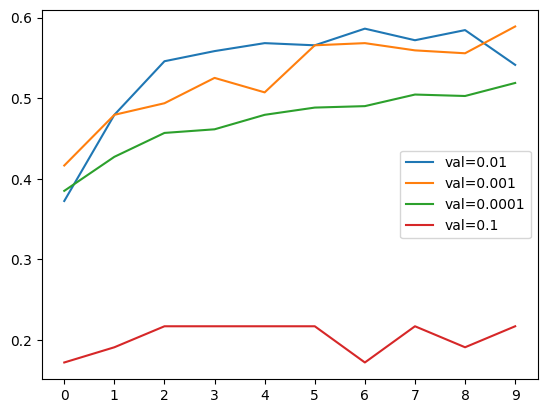

In [31]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [ ]:
## We can select 